# Data visualization around the Grenoble 2020 elections - followers & friends

## Loading the data

In [1]:
%load_ext autoreload
%autoreload 2
%load_ext rpy2.ipython
import pandas
import os
from plotnine import *
import plotnine
plotnine.options.figure_size = (12, 8)
import twitter as tw

/home/tom/.cache/pypoetry/virtualenvs/twitter-data-NGoNO7rx-py3.7/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:14: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex
/home/tom/.cache/pypoetry/virtualenvs/twitter-data-NGoNO7rx-py3.7/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:34: UserWarning: pandas >= 1.0 is not supported.
  warnings.warn('pandas >= 1.0 is not supported.')


In [2]:
users = {
    'EricPiolle': 'Grenoble en Commun',
    'Grenoble_Commun': 'Grenoble en Commun',
    'EmilieCChalas': 'Un Nouveau Regard sur Grenoble',
    'Chalas2020': 'Un Nouveau Regard sur Grenoble',
    'CarignonAlain': 'Grenoble le Changement',
    'onoblecourt': 'Grenoble Nouvel Air',
    'GrenobleNvAir': 'Grenoble Nouvel Air',
    'CommuneEstANous': 'La commune est à nous !',
    'MireilledOrnano': 'Mieux vivre à Grenoble',
}
names = {
    'EricPiolle': 'Éric Piolle',
    'EmilieCChalas': 'Emilie Chalas',
    'CarignonAlain': 'Alain Carignon',
    'onoblecourt': 'Olivier Noblecourt',
    'MireilledOrnano': "Mireille d'Ornano",
    'Grenoble_Commun': 'Grenoble en Commun',
    'Chalas2020': 'Un Nouveau Regard sur Grenoble',
    'GrenobleNvAir': 'Grenoble Nouvel Air',
    'CommuneEstANous': 'La commune est à nous !',
}
colors = {
    'Grenoble en Commun': '#00c000',
    'Un Nouveau Regard sur Grenoble': '#ffb400',
    'Grenoble le Changement': '#0066CC',
    'Grenoble Nouvel Air': '#ff8080',
    'La commune est à nous !': '#bb0000',
    'Mieux vivre à Grenoble': '#0D378A'
}
colors2 = {names[n]: colors[users[n]] for n in names}

In [3]:
follower_files = [
    'followers/CarignonAlain.csv',
    'followers/EmilieCChalas.csv',
    'followers/onoblecourt.csv',
    'followers/EricPiolle.csv',
    'followers/MireilledOrnano.csv',
]

friend_files = [
    'friends/CarignonAlain.csv',
    'friends/EmilieCChalas.csv',
    'friends/onoblecourt.csv',
    'friends/EricPiolle.csv',
    'friends/MireilledOrnano.csv',
]

follower_files += [
    'followers_lists/Grenoble_Commun.csv',
    'followers_lists/GrenobleNvAir.csv',
    'followers_lists/Chalas2020.csv',
    'followers_lists/CommuneEstANous.csv',
]

friend_files += [
    'friends_lists/Grenoble_Commun.csv',
    'friends_lists/GrenobleNvAir.csv',
    'friends_lists/Chalas2020.csv',
    'friends_lists/CommuneEstANous.csv',
]

filenames = follower_files + friend_files

data = []
for f in filenames:
    login = f.split('/')[1].split('.')[0]
    relation = 'followers' if 'follower' in f else 'friends'
    tmp = pandas.read_csv(f)
    tmp['relation'] = relation
    tmp['candidate_login'] = login
    tmp['candidate_name'] = names[login]
    tmp['candidate_tag'] = users[login]
    data.append(tmp)
df = pandas.concat(data)
df['date'] = pandas.to_datetime(df['date'])

print(len(df), len(df.columns))

68463 19


In [4]:
df.groupby('candidate_name')[['date']].agg(['min', 'max', 'count'])

date                           
                                               min                 max  count
candidate_name                                                               
Alain Carignon                 2007-01-02 01:48:14 2020-02-24 09:12:58   7272
Emilie Chalas                  2007-03-28 12:14:38 2020-02-27 15:15:41   7137
Grenoble Nouvel Air            2007-03-05 22:08:25 2020-02-24 09:12:58    616
Grenoble en Commun             2007-03-28 12:14:38 2020-02-28 19:58:25   1561
La commune est à nous !        2007-09-03 17:11:53 2020-02-24 09:12:58    439
Mireille d'Ornano              2007-02-01 07:44:29 2020-02-28 08:50:02   6511
Olivier Noblecourt             2006-12-08 15:00:33 2020-02-24 09:12:58   6404
Un Nouveau Regard sur Grenoble 2008-12-06 16:59:14 2020-02-28 14:48:49    432
Éric Piolle                    2006-12-08 07:58:42 2020-02-27 20:40:58  38091

## Followers sharing

In [5]:
def compute_sharing_matrix(df):
    tmp = []
    for c1 in df['candidate_name'].unique():
        for c2 in df['candidate_name'].unique():
            nb = len(set(df[df['candidate_name'] == c1]['id']) & set(df[df['candidate_name'] == c2]['id']))
            total = len(df[df['candidate_name'] == c1])
            percent = nb/total * 100
            txt_a = f'{percent:.1f}%' if percent < 100 else ''
            txt_b = f'{nb}/{total}' if percent < 100 else ''
            txt = f'{txt_b}\n{txt_a}'
           # txt = txt_b
            if c1 == c2:
                nb = 0
                percent = 0
            tmp.append({
                'candidate': c1,
                'other': c2,
                'nb_common': nb,
                'percent_shared': percent,
                'text': txt
            })
    return pandas.DataFrame(tmp)
shared_followers = compute_sharing_matrix(df[df['relation'] == 'followers'])
shared_followers

,candidate,other,nb_common,percent_shared,text
0,Alain Carignon,Alain Carignon,0,0.000000,\n
1,Alain Carignon,Emilie Chalas,483,17.237687,483/2802\n17.2%
2,Alain Carignon,Olivier Noblecourt,322,11.491792,322/2802\n11.5%
3,Alain Carignon,Éric Piolle,844,30.121342,844/2802\n30.1%
4,Alain Carignon,Mireille d'Ornano,146,5.210564,146/2802\n5.2%
...,...,...,...,...,...
76,La commune est à nous !,Mireille d'Ornano,21,12.804878,21/164\n12.8%
77,La commune est à nous !,Grenoble en Commun,92,56.097561,92/164\n56.1%
78,La commune est à nous !,Grenoble Nouvel Air,77,46.951220,77/164\n47.0%
79,La commune est à nous !,Un Nouveau Regard sur Grenoble,55,33.536585,55/164\n33.5%


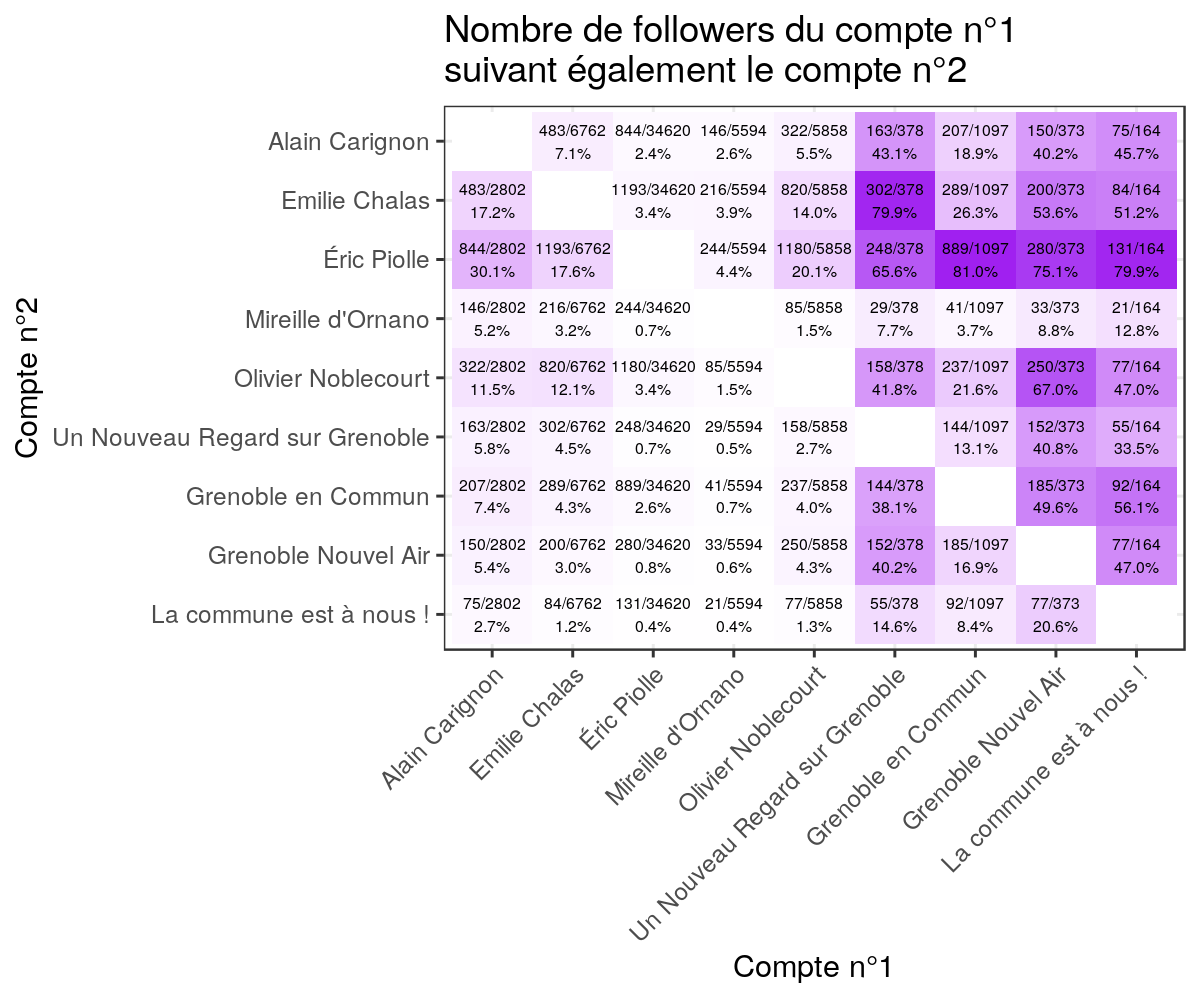

In [6]:
%%R -i shared_followers -w 6 -h 5 --units in -r 200

library(ggplot2)

order_list = c(
    'Alain Carignon',
    'Emilie Chalas',
    'Éric Piolle',
    "Mireille d'Ornano",
    'Olivier Noblecourt',
    'Un Nouveau Regard sur Grenoble',
    'Grenoble en Commun',
    'Grenoble Nouvel Air',
    'La commune est à nous !'
)

plot = ggplot(shared_followers) +
    aes(x=candidate, y=other, fill=percent_shared) +
    geom_tile() +
    theme_bw() +
    scale_fill_gradient2(high = "purple") +
    geom_text(aes(label = text), color = "black", size=2) +
    xlab('Compte n°1') +
    ylab('Compte n°2') +
    theme(legend.position='none') +
    theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
    scale_x_discrete(limits=order_list) +
    scale_y_discrete(limits=rev(order_list)) +
    ggtitle('Nombre de followers du compte n°1\nsuivant également le compte n°2')
ggsave('/tmp/shared_followers.png', plot, width=7, height=6)
plot

## Localisation

In [7]:
import re

def count_locations(df, locations):
    df = df.copy()
    df.loc[df['location'].isna(), 'location'] = 'no_location'
    result = []
    for login in df['candidate_login'].unique():
        tmp = df[df['candidate_login'] == login]
        for loc in locations:
            loc = '|'.join(loc)
            nb_loc = len(tmp['location'].str.extractall(r'(?P<ville>%s)' % loc, re.IGNORECASE))
            nb_total = len(tmp)
            txt = f'{nb_total} followers'.rjust(15)
            result.append({
                'login': login,
                'name': names[login],
                'tag': users[login],
                'location': loc,
                'count': nb_loc,
                'percent': nb_loc/nb_total*100,
                'total': nb_total,
                'txt': txt,
            })
    result = pandas.DataFrame(result)
    return result


def count_locations_fr(df):
    locations = count_locations(df, [['Grenoble'], ['Paris']])
    others = count_locations(df, [['Nantes', 'Rennes', 'Bordeaux', 'Strasbourg', 'Toulouse', 'Marseille', 'Montpellier', 'Nice', 'Lyon']])
    others['location'] = 'Grandes villes\nfrançaises'
    noloc = count_locations(df, [['no_location']])
    noloc['location'] = 'Non spécifiée'
 #   locations = pandas.concat([locations, others, noloc])
    locations = pandas.concat([locations, others])
    return locations

locations = count_locations_fr(df[df['relation'] == 'followers'])
locations['color'] = locations.apply(lambda row: colors[row['tag']], axis=1)
locations

,login,name,tag,location,count,percent,total,txt,color
0,CarignonAlain,Alain Carignon,Grenoble le Changement,Grenoble,396,14.132762,2802,2802 followers,#0066CC
1,CarignonAlain,Alain Carignon,Grenoble le Changement,Paris,209,7.458958,2802,2802 followers,#0066CC
2,EmilieCChalas,Emilie Chalas,Un Nouveau Regard sur Grenoble,Grenoble,474,7.009760,6762,6762 followers,#ffb400
3,EmilieCChalas,Emilie Chalas,Un Nouveau Regard sur Grenoble,Paris,930,13.753327,6762,6762 followers,#ffb400
4,onoblecourt,Olivier Noblecourt,Grenoble Nouvel Air,Grenoble,402,6.862410,5858,5858 followers,#ff8080
5,onoblecourt,Olivier Noblecourt,Grenoble Nouvel Air,Paris,1162,19.836122,5858,5858 followers,#ff8080
6,EricPiolle,Éric Piolle,Grenoble en Commun,Grenoble,3685,10.644136,34620,34620 followers,#00c000
7,EricPiolle,Éric Piolle,Grenoble en Commun,Paris,2230,6.441363,34620,34620 followers,#00c000
8,MireilledOrnano,Mireille d'Ornano,Mieux vivre à Grenoble,Grenoble,83,1.483733,5594,5594 followers,#0D378A
9,MireilledOrnano,Mireille d'Ornano,Mieux vivre à Grenoble,Paris,311,5.559528,5594,5594 followers,#0D378A


R[write to console]: 
Attachement du package : ‘dplyr’


R[write to console]: The following objects are masked from ‘package:stats’:

    filter, lag


R[write to console]: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




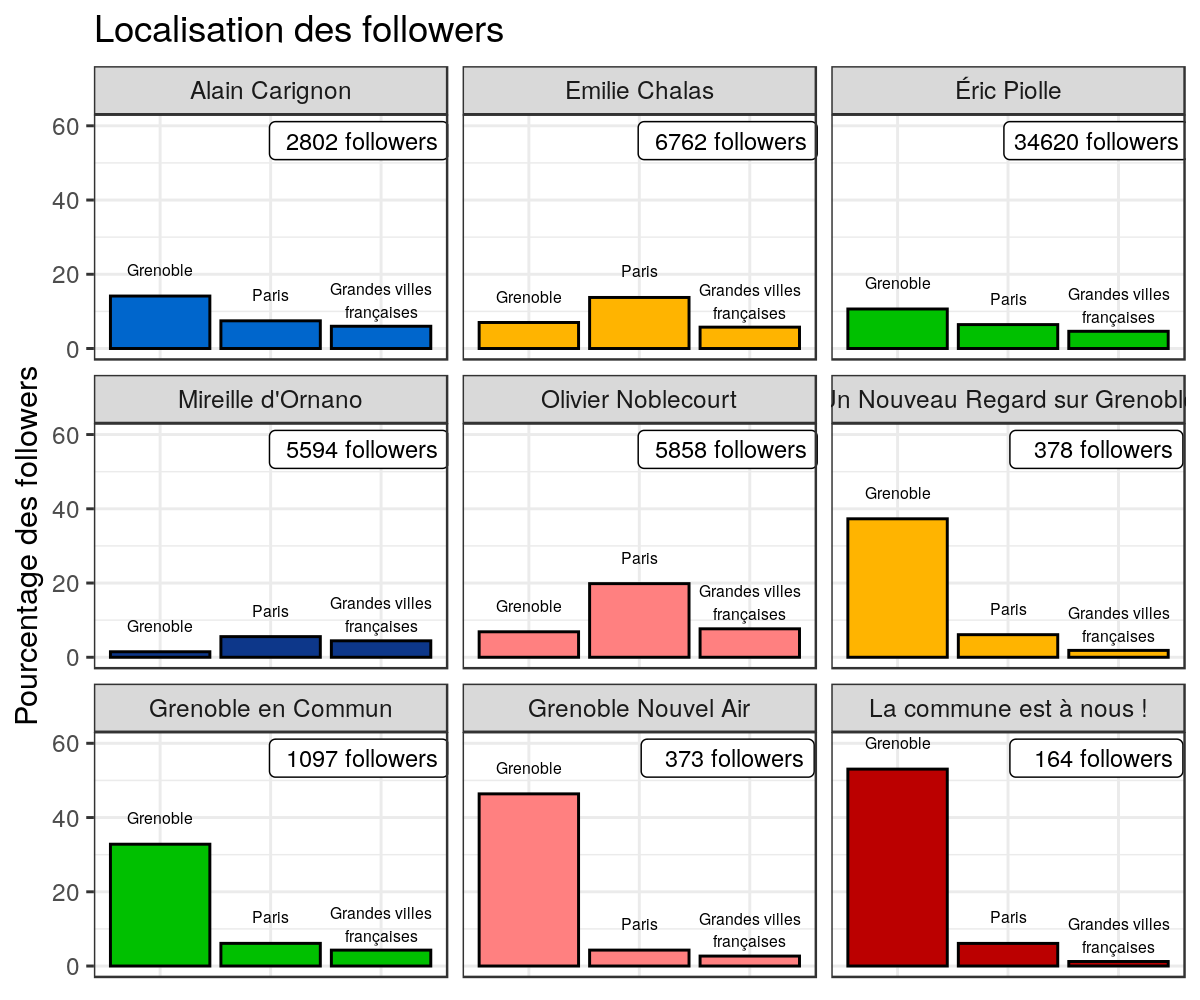

In [8]:
%%R -i locations -w 6 -h 5 --units in -r 200

library(dplyr)

locations$name = factor(locations$name, levels=order_list)
colors = (locations %>% arrange(name) %>% select(name, color) %>% unique())$color
txt = locations %>% filter(location == 'Paris') %>% mutate(percent=40)

plot = ggplot(locations) +
    aes(x=location, y=percent, group=name) +
    geom_bar(aes(fill=name, group=name), stat='identity', color='black', position='dodge') +
    theme_bw() +
    geom_label(data=txt, aes(label=txt), position=position_nudge(x = 0.8, y=16), size=3) +
    geom_text(aes(label=location, y=percent+7), size=2) +
    scale_fill_manual(values = colors) +
    ylab('Pourcentage des followers') +
    xlab('Ville') +
    labs(fill='Nom') +
    scale_x_discrete(limits=c('Grenoble', 'Paris', 'Grandes villes\nfrançaises')) +
    ggtitle('Localisation des followers') +
    theme(legend.position='none') +
    theme(axis.text.x = element_text(size=6)) +
    theme(axis.title.x=element_blank(), axis.text.x=element_blank(), axis.ticks.x=element_blank()) +
    facet_wrap('name')
ggsave('/tmp/followers_locations.png', plot, width=7, height=6)
plot

In [9]:
for name in df['candidate_name'].unique():
    print(name)
    tmp = df[(df['relation'] == 'followers') & (df['candidate_name'] == name)].groupby(['location'])[['id']].count()
    print(tmp.sort_values(by='id', ascending=False).head(n=5).reset_index())
    print()

Alain Carignon
           location   id
0  Grenoble, France  195
1            France  166
2          Grenoble  102
3     Paris, France   86
4      Lyon, France   42

Emilie Chalas
           location   id
0     Paris, France  440
1            France  331
2  Grenoble, France  253
3             Paris  227
4          Grenoble  124

Olivier Noblecourt
           location   id
0     Paris, France  517
1             Paris  320
2            France  278
3          Grenoble  146
4  Grenoble, France  145

Éric Piolle
           location    id
0  Grenoble, France  2108
1            France  1094
2     Paris, France   888
3          Grenoble   848
4             Paris   678

Mireille d'Ornano
                location   id
0                 France  373
1          Paris, France  163
2              Nicaragua   75
3  Ile-de-France, France   56
4                  Paris   55

Grenoble en Commun
             location   id
0    Grenoble, France  186
1            Grenoble   96
2              France   34
3   